In [2]:
import pandas as pd
import numpy as np

file1_path = 'C:\Users\User\Dropbox\taishin\taishin_files\file1.csv'
file2_path = 'C:\Users\User\Dropbox\taishin\taishin_files\file2.csv'
file3_path = 'C:\Users\User\Dropbox\taishin\taishin_files\file3.csv'

df1 = pd.read_csv(file1_path)
df2 = pd.read_csv(file2_path)
df3 = pd.read_csv(file3_path)

df1.columns = df1.columns.str.strip()
df2.columns = df2.columns.str.strip()
df3.columns = df3.columns.str.strip()

df1.set_index('srno_2', inplace=True)
df2.set_index('srno_2', inplace=True)
df3.set_index('srno_2', inplace=True)

df2['YN_Web_Active'] = df2['YN_Web_Active'].replace({'Y': 1, np.nan: 0}).astype(int)
df2['YN_secur'] = df2['YN_secur'].replace({'Y': 1, np.nan: 0}).astype(int)
df2['YN_SLR'] = df2['YN_SLR'].replace({'Y': 1, np.nan: 0}).astype(int)
df2['YN_SLR'] = df2['YN_SLR'].replace({'Y': 1, np.nan: 0}).astype(int)
df1['intr_12'] = df1['intr_12'].replace({'Y': 1,0:0}).astype(int)
df1['intr_13'] = df1['intr_13'].replace({'Y': 1,0:0}).astype(int)

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 2-3: truncated \UXXXXXXXX escape (803555234.py, line 4)

In [123]:

sub_dataframes = [group for _, group in df2.groupby(pd.to_datetime(df2['yyyymm'], format='%Y%m').dt.to_period('M'))]

identical_features = set(sub_dataframes[0].columns) 
for col in sub_dataframes[0].columns:

    for other_df in sub_dataframes[1:]:
        if not sub_dataframes[0][col].equals(other_df[col]):

            if col in identical_features:
                identical_features.remove(col)
            break

print("完全相同的features:", identical_features)


完全相同的features: set()


# Encode

## 新特征

In [131]:
for col in ['cumsum_1', 'cumsum_2', 'cumsum_3']:
    sub_dataframes[0][col] = 0

for i in range(1, len(sub_dataframes)):
    sub_dataframes[i]['cumsum_3'] = sub_dataframes[i]['rs_prod_3'] + sub_dataframes[i-1]['cumsum_3']
    sub_dataframes[i]['cumsum_2'] = sub_dataframes[i]['rs_prod_2'] + sub_dataframes[i-1]['cumsum_2']
    sub_dataframes[i]['cumsum_1'] = sub_dataframes[i]['rs_prod_1'] + sub_dataframes[i-1]['cumsum_1']

for col in ['cumsum_1', 'cumsum_2', 'cumsum_3']:
    df1[col] = sub_dataframes[-1][col]

for col in ['rs_prod_3', 'rs_prod_2', 'rs_prod_1']:
    df1[col] = (df1[f'cumsum_{col[-1]}'] != 0).astype(int)

df1['consumer']  = df1['rs_prod_3'] + df1['rs_prod_2'] + df1['rs_prod_1'] 
df2['user'] = df2['rs_prod_3'] + df2['rs_prod_2'] + df2['rs_prod_1'] 


## 分箱

In [ ]:
df1['age_group'] = pd.cut(df1['age'], bins=range(20,df1['age'].max()+10, 10), right=False)
df1 = df1.drop('age',axis=1)

## 組合

In [113]:
df1['gender-mry'] = df1['gender'].astype(str)+'-'+df1['mry'].astype(str)
df1['intr-12-13'] = df1['intr_12'].astype(str)+'-'+df1['intr_13'].astype(str)
df1 = df1.drop(['gender','mry','intr_12','intr_13'],axis=1)

# EDA

## 問題描述

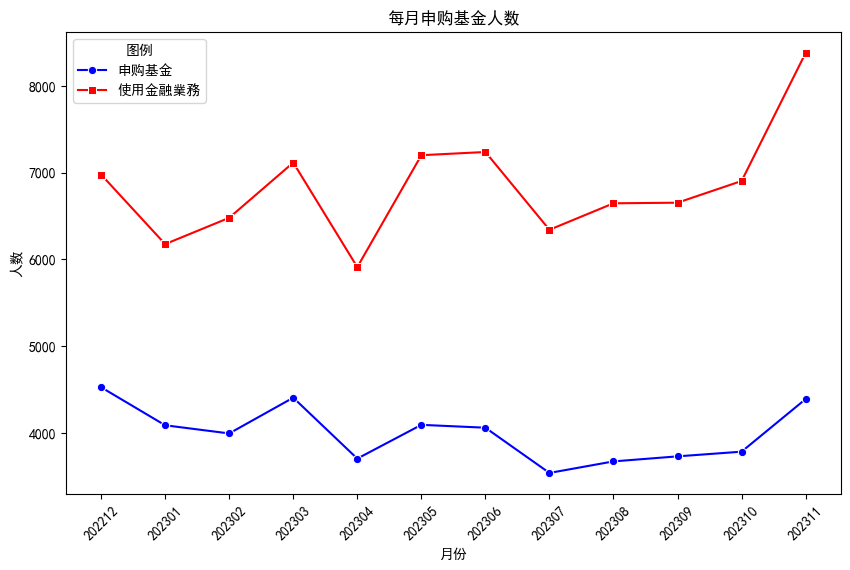

In [132]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.font_manager import FontProperties

plt.rcParams['font.family'] = 'SimHei' 
counts_df = df2.groupby("yyyymm")["rs_prod_3"].value_counts().unstack().fillna(0)
user_df = df2.groupby("yyyymm")['user'].value_counts().unstack().fillna(0)

plt.figure(figsize=(10, 6))

sns.lineplot(x=counts_df.index.astype(str), y=counts_df[1], marker='o', color='b', label='申购基金')
sns.lineplot(x=counts_df.index.astype(str), y=user_df[1], marker='s', color='r', label='使用金融業務')

plt.xlabel("月份")
plt.ylabel("人数")
plt.title("每月申购基金人数")
plt.xticks(rotation=45)

plt.legend(title='图例')

plt.show()

<Figure size 1000x600 with 0 Axes>

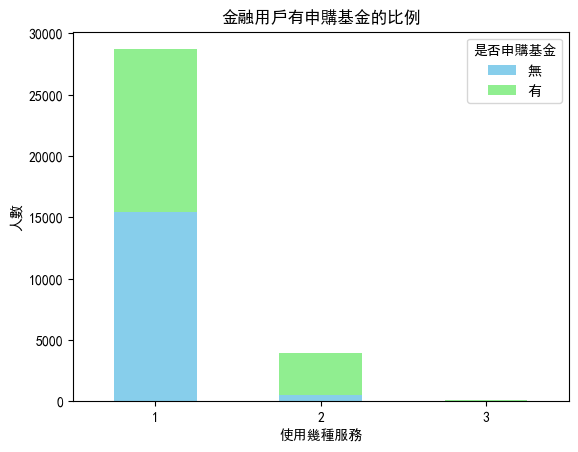

In [133]:
filtered_df = df1[df1['consumer'] != 0]

rs_prod_3_counts = filtered_df.groupby('consumer')['rs_prod_3'].value_counts().unstack(fill_value=0)

plt.figure(figsize=(10, 6))
rs_prod_3_counts.plot(kind='bar', stacked=True, color=['skyblue', 'lightgreen'])
plt.title('金融用戶有申購基金的比例')
plt.xlabel('使用幾種服務')
plt.ylabel('人數')
plt.xticks(rotation=0)  
plt.legend(title='是否申購基金', labels=['無', '有'])  
plt.show()

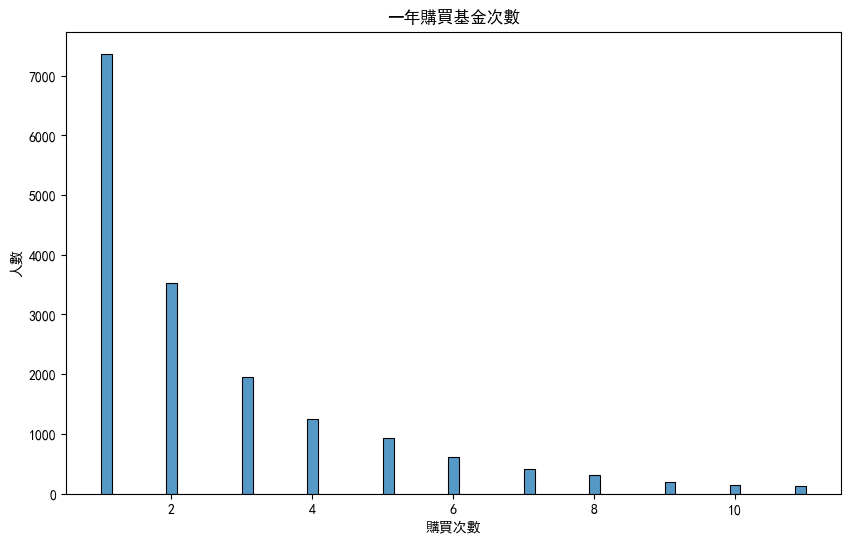

In [134]:
plt.figure(figsize=(10, 6))
sns.histplot(df1[df1['cumsum_3'] != 0]['cumsum_3'] )
plt.title('一年購買基金次數')
plt.xlabel('購買次數')
plt.ylabel('人數')
plt.xticks(rotation=0)   
plt.show()

## 年資料

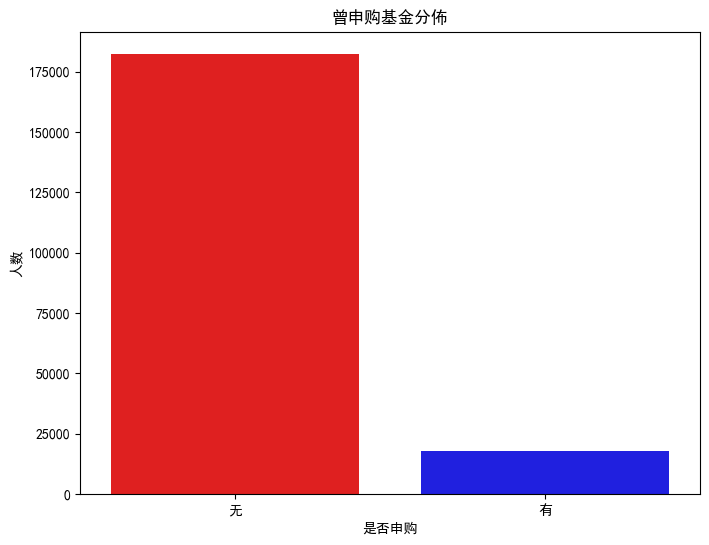

In [8]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='rs_prod_3', hue='rs_prod_3', data=df1, palette={0: 'red', 1: 'blue'}, dodge=False)
ax.set_title('曾申购基金分佈')
ax.set_xlabel('是否申购')
ax.set_ylabel('人数')
ax.set_xticks([0, 1])
ax.set_xticklabels(['无', '有'])
ax.legend().set_visible(False)



### 依年齡 縣市

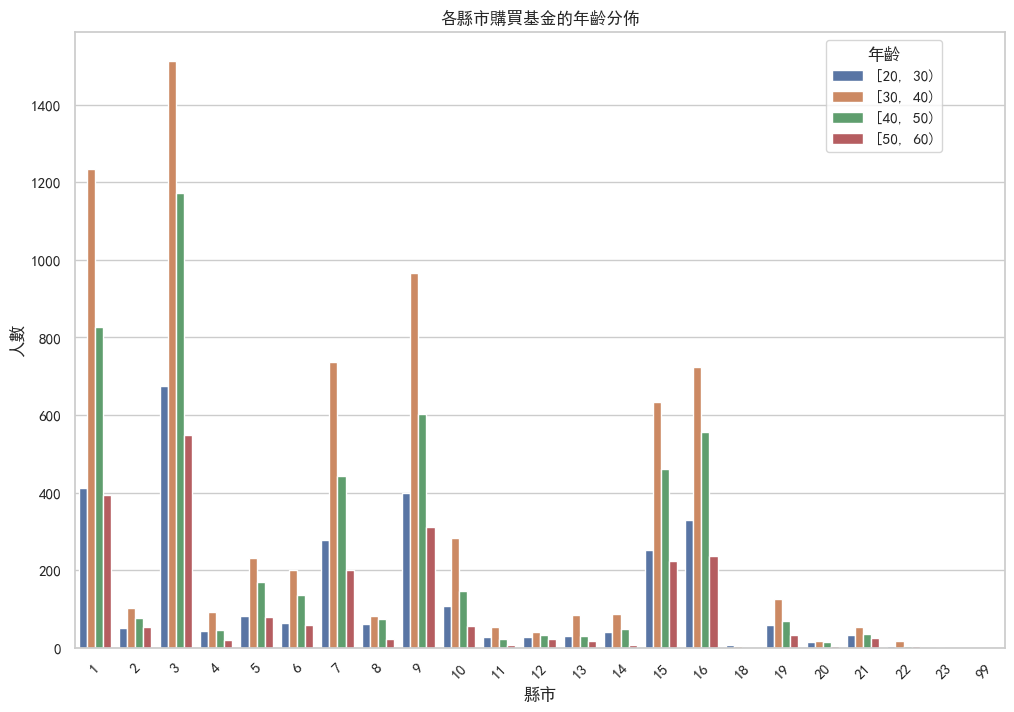

In [421]:
age_group_counts = df1['age_group'].value_counts().sort_index()
age_groups_str = [str(interval) for interval in age_group_counts.index]
group_counts = df1.loc[df1['rs_prod_3'] == 1].groupby(['age_group', 'zip'], observed=False).size().reset_index(name='count')

plt.figure(figsize=(12, 8))
barplot = sns.barplot(x='zip', y='count', hue='age_group', data= group_counts)
plt.title('各縣市購買基金的年齡分佈')
plt.xlabel('縣市')
plt.ylabel('人數')
plt.xticks(rotation=45)
plt.legend(title='年齡', bbox_to_anchor=(0.8, 1), loc='upper left')
plt.show()   

### 依性別-婚姻

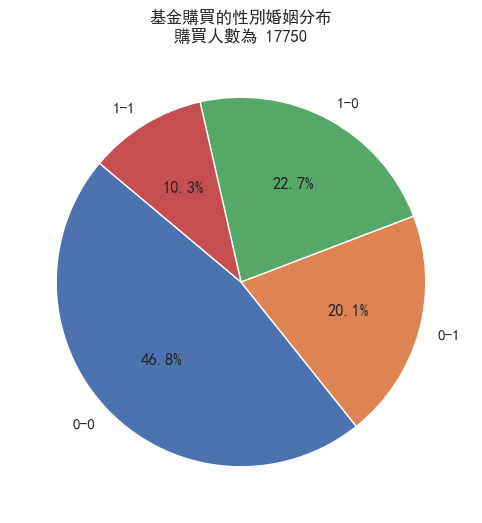

In [422]:
filtered_data = df1[df1['rs_prod_3'] == 1]

group_counts = filtered_data.groupby('gender-mry').size()
total_purchases = np.sum(df1['rs_prod_3'] == 1)  

plt.figure(figsize=(8, 6))
plt.pie(group_counts, labels=group_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f'基金購買的性別婚姻分布\n購買人數為 {total_purchases}') 
plt.show()


### intr

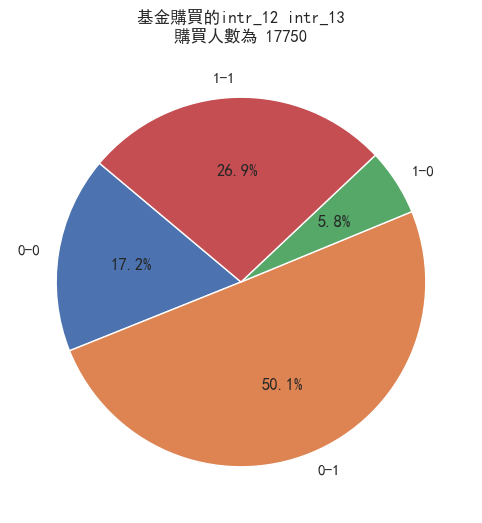

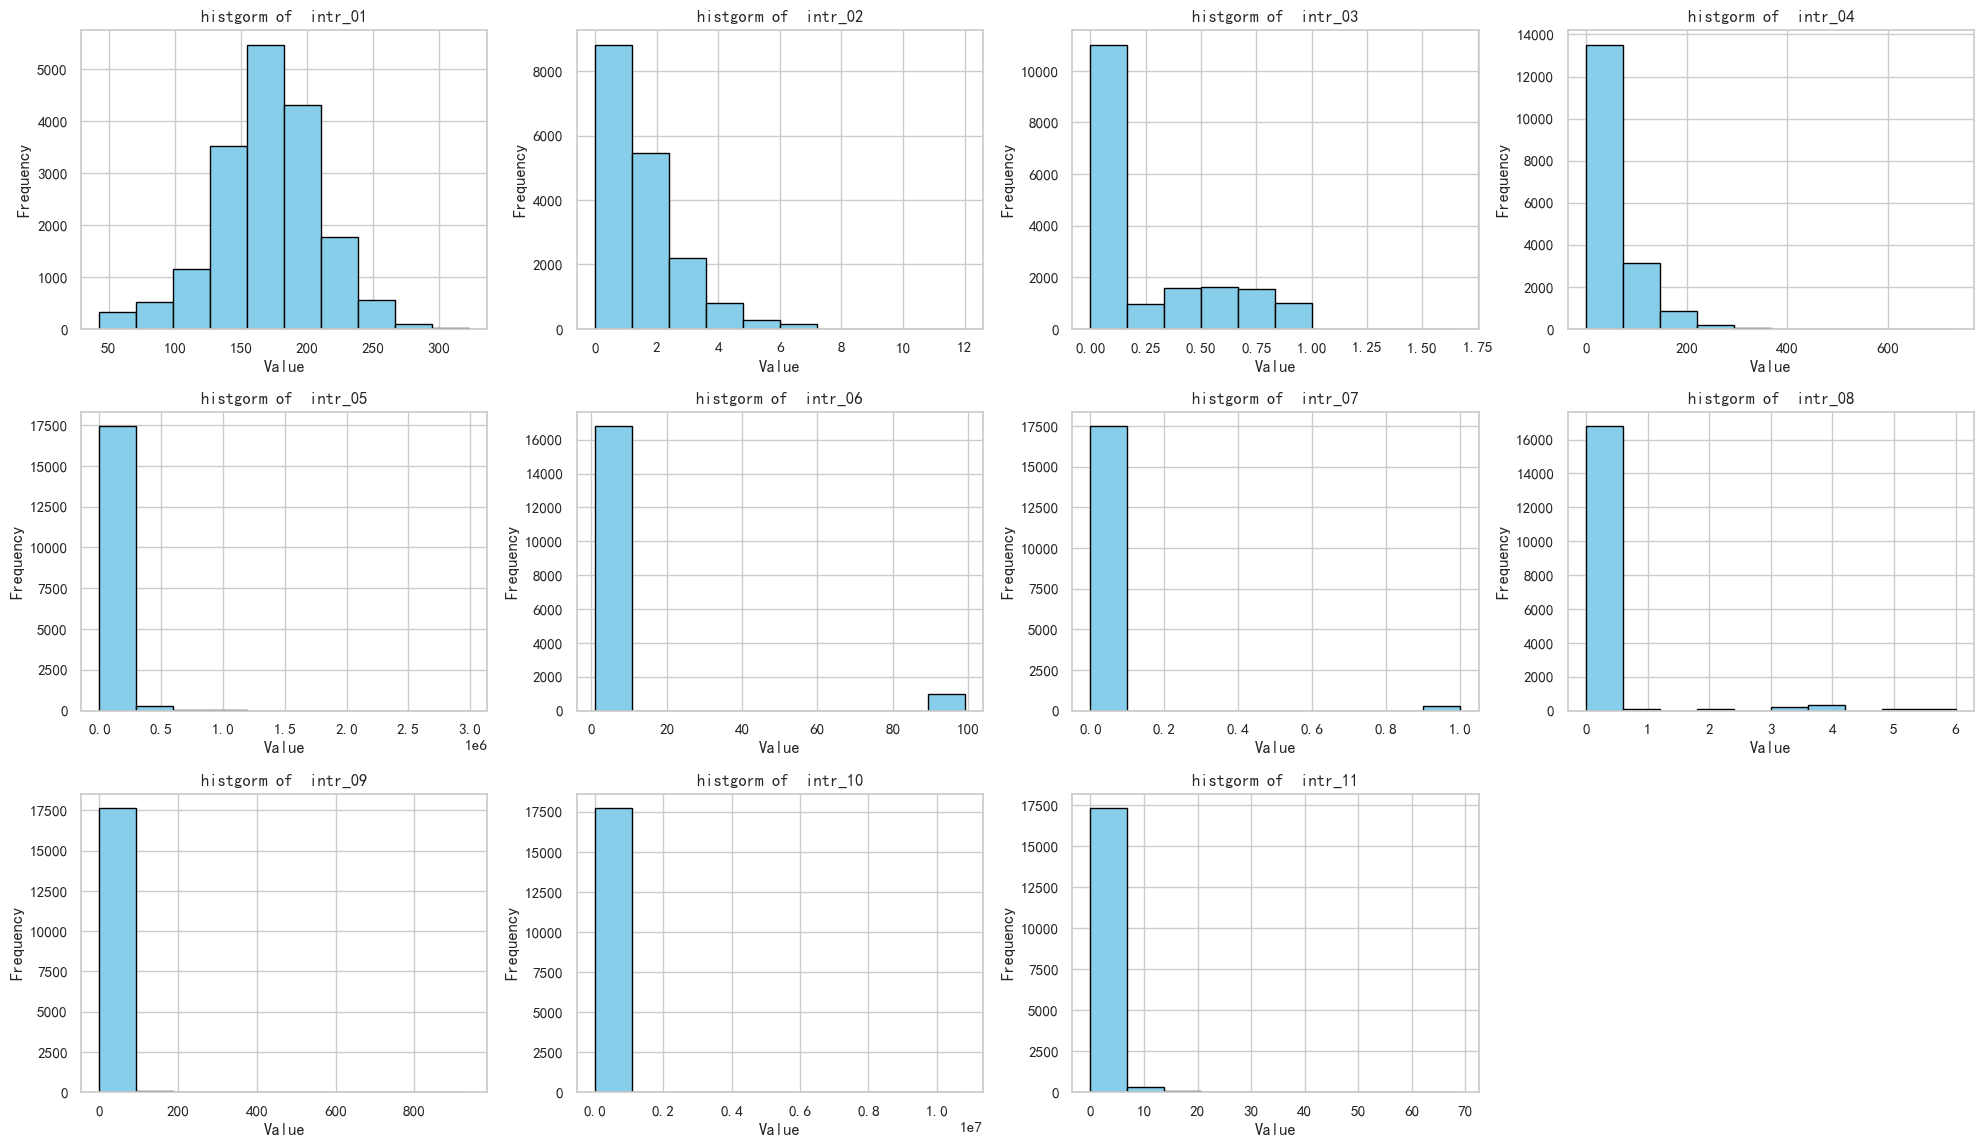

In [423]:
group_counts = filtered_data.groupby('intr-12-13').size()
total_purchases = np.sum(df1['rs_prod_3'] == 1)  

plt.figure(figsize=(8, 6))
plt.pie(group_counts, labels=group_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f'基金購買的intr_12 intr_13\n購買人數為 {total_purchases}') 
plt.show()

filtered_data = df1[df1['rs_prod_3'] == 1]

plt.figure(figsize=(20, 15))

# 對每個interest variable進行繪圖
for i in range(1, 12):
    plt.subplot(4, 4, i)  # 創建4行3列的子圖，並在第i個位置繪製
    plt.hist(filtered_data[f'intr_{i:02d}'],color='skyblue', edgecolor='black')  # 確保i是兩位數
    plt.title(f'histgorm of  intr_{i:02d}')
    plt.xlabel(f'Value')
    plt.ylabel('Frequency')

plt.tight_layout()  
plt.show()

### 依照教育-職業

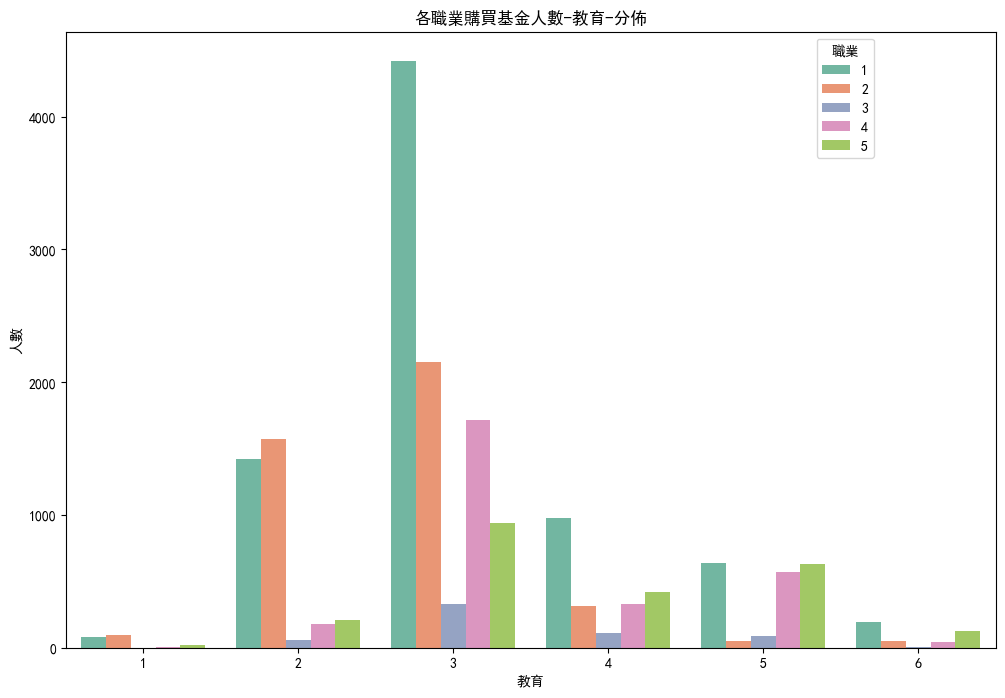

In [96]:
group_counts = df1['edu'].value_counts().sort_index()

group_counts = df1.loc[df1['rs_prod_3'] == 1].groupby(['edu', 'job'], observed=False).size().reset_index(name='count')

plt.figure(figsize=(12, 8))
sns.barplot(x='edu', y='count', hue='job', data=group_counts, palette=sns.color_palette("Set2",n_colors= df1['job'].nunique()))

plt.title('各職業購買基金人數-教育-分佈')
plt.xlabel('教育')
plt.ylabel('人數')
plt.legend(title='職業', bbox_to_anchor=(0.8, 1), loc='upper left')
plt.show()

## 月資料

In [144]:
# high_correlation_columns = {}
# for i, sub in enumerate(sub_dataframes):
    
#     cor = np.abs(sub.corr())

#     cols = cor.columns
#     pairs = [(cols[x], cols[y]) for x in range(len(cols)) for y in range(x+1, len(cols)) if cor.iloc[x, y] > 0.8]
    
#     high_correlation_columns[f'sub_{i}'] = pairs   
# high_correlation_columns    


from sklearn.preprocessing import LabelEncoder
non_numeric_columns = df1.select_dtypes(exclude=[np.number]).columns
label_encoders = {}
for column in non_numeric_columns:
    le = LabelEncoder()
    df1[column] = le.fit_transform(df1[column])
    label_encoders[column] = le  
    
from sklearn.decomposition import PCA

df2 = pd.merge(pd.concat(sub_dataframes), df1.drop(['rs_prod_3','rs_prod_2','rs_prod_1','cumsum_1', 'cumsum_2', 'cumsum_3','consumer'], axis=1), on='srno_2', how='left')
df2['user'] = df2['rs_prod_3'] + df2['rs_prod_2'] + df2['rs_prod_1'] 


C:\Users\USER\AppData\Local\Temp\ipykernel_1936\781437104.py:43: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  plt.tight_layout()
C:\Users\USER\AppData\Roaming\Python\Python311\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


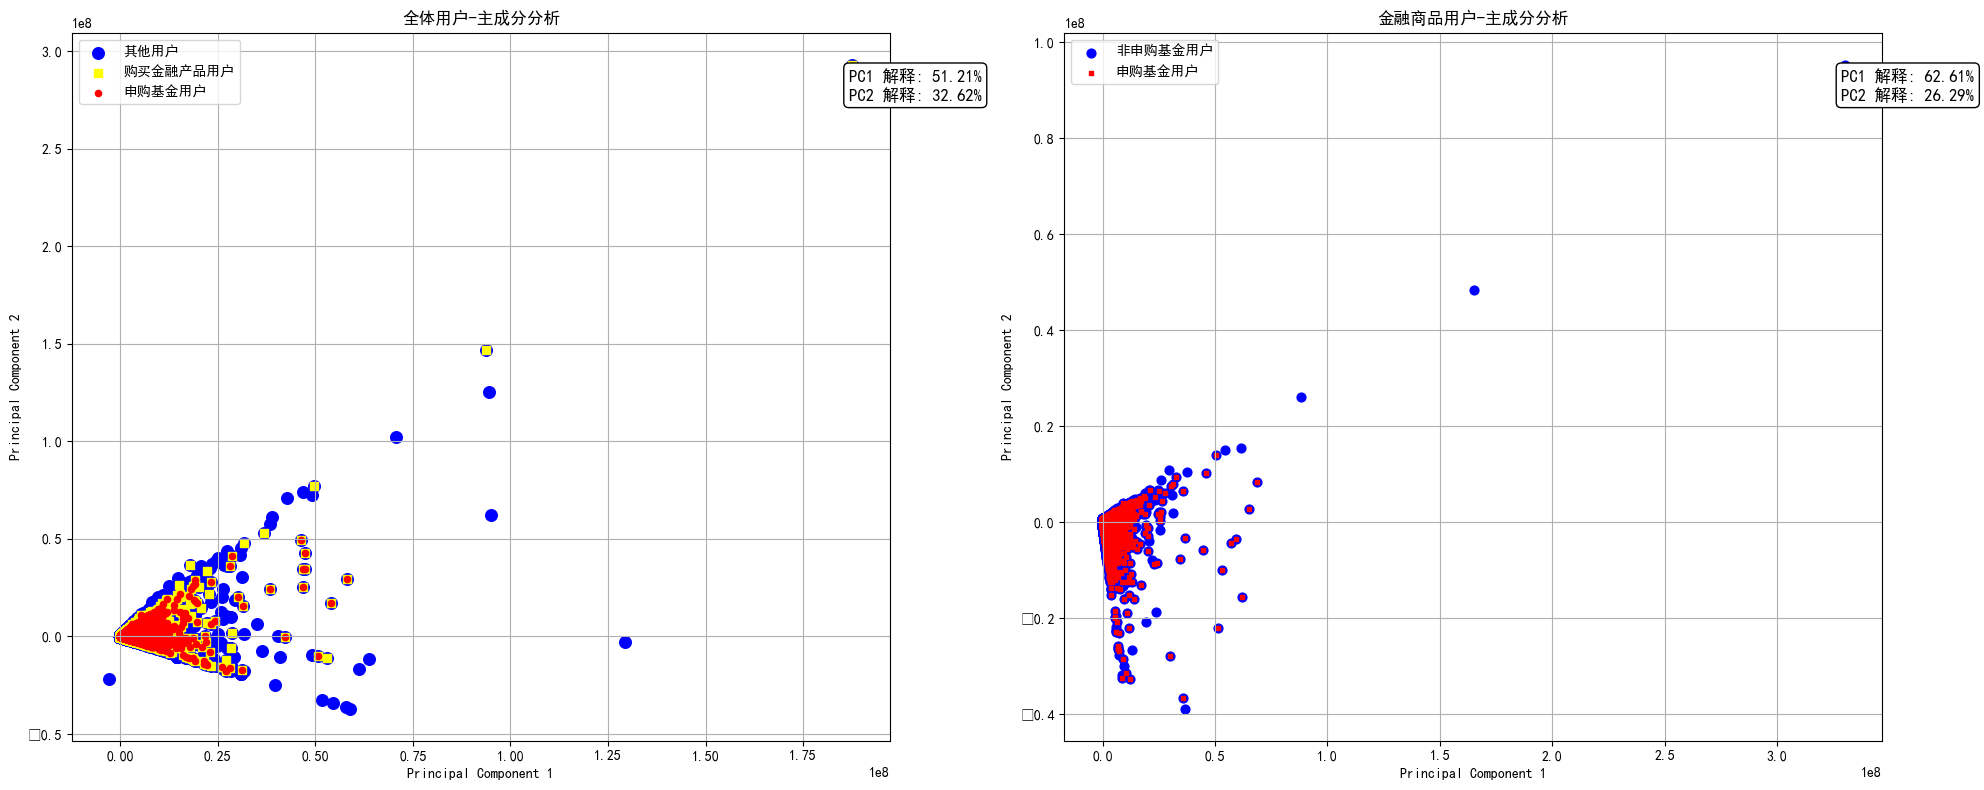

In [148]:
#Prepare data for PCA
df_reduced1 = df2.drop(['rs_prod_3','yyyymm','cumsum_1','cumsum_2','cumsum_3'], axis=1)
pca1 = PCA(n_components=2)
pca_results1 = pca1.fit_transform(df_reduced1)
pca_df1 = pd.DataFrame(pca_results1, columns=['PC1', 'PC2'], index=df2.index)
pca_df1['consumer'] = df2['user']
pca_df1['rs_prod_3'] = df2['rs_prod_3']

df_reduced2 = df2[df2['user'] != 0].drop(['rs_prod_3','yyyymm','cumsum_1','cumsum_2','cumsum_3'], axis=1)
pca2 = PCA(n_components=2)
pca_results2 = pca2.fit_transform(df_reduced2)
pca_df2 = pd.DataFrame(pca_results2, columns=['PC1', 'PC2'], index=df_reduced2.index)
pca_df2['rs_prod_3'] = df2['rs_prod_3'][df2['user'] != 0]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

ax1.scatter(pca_df1['PC1'], pca_df1['PC2'], s=70, c='blue', marker='o', label='其他用户')
consumer_mask = pca_df1['consumer'] != 0
ax1.scatter(pca_df1.loc[consumer_mask, 'PC1'], pca_df1.loc[consumer_mask, 'PC2'], s=40, c='yellow', marker='s', label='购买金融产品用户')
rs_prod_3_mask = pca_df1['rs_prod_3'] != 0
ax1.scatter(pca_df1.loc[rs_prod_3_mask, 'PC1'], pca_df1.loc[rs_prod_3_mask, 'PC2'], s=20, c='red', marker='o', label='申购基金用户')
ax1.set_title('全体用户-主成分分析')
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.legend()
ax1.grid(True)

ax2.scatter(pca_df2['PC1'], pca_df2['PC2'], s=40, c='blue', marker='o', label='非申购基金用户')
rs_prod_3_mask = pca_df2['rs_prod_3'] != 0
ax2.scatter(pca_df2.loc[rs_prod_3_mask, 'PC1'], pca_df2.loc[rs_prod_3_mask, 'PC2'], s=10, c='red', marker='s', label='申购基金用户')
ax2.set_title('金融商品用户-主成分分析')
ax2.set_xlabel('Principal Component 1')
ax2.set_ylabel('Principal Component 2')
ax2.legend()
ax2.grid(True)

# Adding explained variance
for ax, pca, title in zip([ax1, ax2], [pca1, pca2], ['全体用户', '金融商品用户']):
    explained_var = pca.explained_variance_ratio_ * 100
    explained_text = f'PC1 解释: {explained_var[0]:.2f}%\nPC2 解释: {explained_var[1]:.2f}%'
    ax.text(0.95, 0.95, explained_text, verticalalignment='top', horizontalalignment='left', transform=ax.transAxes, fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor='black', facecolor='white'))

plt.tight_layout()
plt.show()

# Model Traing

## Featrtures Slection

In [ ]:
# 先使用LightGBM predict Cross section

## 切割 未開發用戶跟 已開發用戶

In [67]:
user_indices = df1[df1['consumer'] != 0].index
unuser_indices = df1[df1['consumer'] == 0].index

user = df2.loc[user_indices]
unuser = df2.loc[unuser_indices]


## 對於已開發用戶 使用 图卷积模型 找出 會繼續申購 or 開啟申購的機率

## 對於未開發用戶，先使用特定features分群原資料，計算同一group下與已開發用戶相似的未開發用戶，並計算申購的機率

# Model evuluation

## Confustion_mtx

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test)
cm = confusion_matrix(y_test, y_pred.argmax(axis=1))
print('Confusion Matrix')
print(cm)

## AUC_ROC score

In [ ]:
from sklearn.metrics import roc_curve, auc

def plot_roc_curve(model, X, y):
    # 预测概率
    y_pred_proba = model.predict_proba(X)[:, 1]

    # 计算ROC曲线的参数
    fpr, tpr, thresholds = roc_curve(y, y_pred_proba)
    roc_auc = auc(fpr, tpr)

    # 绘制ROC曲线
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()